# Training neural network to predict ball position in a 3d space
## 1. Importing Libraries

In [9]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from utils.evaluate import evaluate_model
from utils.plot_maker import plot_maker_3d

## 2. Importing Data

In [10]:
# get all train data
X_circle_a = pd.read_csv('../data/data-circle/red_ball_coordinates_128px_2024-03-07_15h17m.csv', decimal='.', delimiter=',')
X_circle_b = pd.read_csv('../data/data-circle/red_ball_coordinates_128px_2024-03-07_15h20m.csv', decimal='.', delimiter=',')
X_circle_c = pd.read_csv('../data/data-circle/red_ball_coordinates_128px_2024-03-07_15h23m.csv', decimal='.', delimiter=',')
X_lis_curve_a = pd.read_csv('../data/data-lis-curve/red_ball_coordinates_128px_2024-03-07_14h32m.csv', decimal='.', delimiter=',')
X_lis_curve_b = pd.read_csv('../data/data-lis-curve/red_ball_coordinates_128px_2024-03-07_14h37m.csv', decimal='.', delimiter=',')
X_lis_curve_c = pd.read_csv('../data/data-lis-curve/red_ball_coordinates_128px_2024-03-07_14h41m.csv', decimal='.', delimiter=',')
X_spiral_double_a = pd.read_csv('../data/data-spiral-double/red_ball_coordinates_128px_2024-03-07_14h58m.csv', decimal='.', delimiter=',')
X_spiral_double_b = pd.read_csv('../data/data-spiral-double/red_ball_coordinates_128px_2024-03-07_15h00m.csv', decimal='.', delimiter=',')
X_spiral_down_a = pd.read_csv('../data/data-spiral-down/red_ball_coordinates_128px_2024-03-07_14h50m.csv', decimal='.', delimiter=',')
X_spiral_down_b = pd.read_csv('../data/data-spiral-down/red_ball_coordinates_128px_2024-03-07_14h52m.csv', decimal='.', delimiter=',')
X_spiral_down_c = pd.read_csv('../data/data-spiral-down/red_ball_coordinates_128px_2024-03-07_14h54m.csv', decimal='.', delimiter=',')

In [11]:
# get all the position data
y_circle_a = pd.read_csv('../data/data-circle/positions_xyz_2024-03-07_15h17m.csv', decimal='.', delimiter=',').iloc[4:]
y_circle_b = pd.read_csv('../data/data-circle/positions_xyz_2024-03-07_15h20m.csv', decimal='.', delimiter=',').iloc[4:]
y_circle_c = pd.read_csv('../data/data-circle/positions_xyz_2024-03-07_15h23m.csv', decimal='.', delimiter=',').iloc[4:]
y_lis_curve_a = pd.read_csv('../data/data-lis-curve/positions_xyz_2024-03-07_14h32m.csv', decimal='.', delimiter=',').iloc[4:]
y_lis_curve_b = pd.read_csv('../data/data-lis-curve/positions_xyz_2024-03-07_14h37m.csv', decimal='.', delimiter=',').iloc[4:]
y_lis_curve_c = pd.read_csv('../data/data-lis-curve/positions_xyz_2024-03-07_14h41m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiral_double_a = pd.read_csv('../data/data-spiral-double/positions_xyz_2024-03-07_14h58m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiral_double_b = pd.read_csv('../data/data-spiral-double/positions_xyz_2024-03-07_15h00m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiral_down_a = pd.read_csv('../data/data-spiral-down/positions_xyz_2024-03-07_14h50m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiral_down_b = pd.read_csv('../data/data-spiral-down/positions_xyz_2024-03-07_14h52m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiral_down_c = pd.read_csv('../data/data-spiral-down/positions_xyz_2024-03-07_14h54m.csv', decimal='.', delimiter=',').iloc[4:]


#### 2.1 Check for Missing Values

In [12]:
print(f'The amount of NaN in spiral_down_b: {X_spiral_down_b.isna().sum().sum()}')
print(f'The amount of NaN in spiral_down_c: {X_spiral_down_c.isna().sum().sum()}')

The amount of NaN in spiral_down_b: 3866
The amount of NaN in spiral_down_c: 3536


In [13]:
X_spiral_down_b.shape, y_spiral_down_b.shape, X_spiral_down_c.shape, y_spiral_down_c.shape

((1017, 14), (1017, 3), (999, 14), (999, 3))

In [14]:
X_spiral_down_b.reset_index(drop=True, inplace=True)
y_spiral_down_b.reset_index(drop=True, inplace=True)
X_spiral_down_c.reset_index(drop=True, inplace=True)
y_spiral_down_c.reset_index(drop=True, inplace=True)

In [15]:
combined_b = pd.concat([X_spiral_down_b, y_spiral_down_b], axis=1)
combined_c = pd.concat([X_spiral_down_c, y_spiral_down_c], axis=1)
combined_b.isna().sum().sum(), combined_c.isna().sum().sum()

(3866, 3536)

#### 2.2 Remove Missing Values
Ball is outside of the frame in the last 300 frames

In [16]:
combined_b = combined_b[:720]
combined_c = combined_c[:720]
combined_b = combined_b.reset_index(drop=True)
combined_c = combined_c.reset_index(drop=True)
# remaining missing values
combined_b.isna().sum().sum(), combined_c.isna().sum().sum()

(34, 0)

In [17]:
X_spiral_down_b = combined_b.iloc[:, :14]
y_spiral_down_b = combined_b.iloc[:, 14:]
X_spiral_down_c = combined_c.iloc[:, :14]
y_spiral_down_c = combined_c.iloc[:, 14:]
X_spiral_down_b.shape, y_spiral_down_b.shape, X_spiral_down_c.shape, y_spiral_down_c.shape

((720, 14), (720, 3), (720, 14), (720, 3))

In [18]:
X_train = pd.concat([X_circle_a, X_circle_b, X_circle_c, X_lis_curve_a, X_lis_curve_b, X_lis_curve_c, X_spiral_double_a, X_spiral_double_b, X_spiral_down_a, X_spiral_down_b, X_spiral_down_c])
y_train = pd.concat([y_circle_a, y_circle_b, y_circle_c, y_lis_curve_a, y_lis_curve_b, y_lis_curve_c, y_spiral_double_a, y_spiral_double_b, y_spiral_down_a, y_spiral_down_b, y_spiral_down_c])
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_train

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6
0,61.0,94.0,43.0,105.0,59.0,87.0,52.5,87.0,36.0,87.5,42.0,80.0,44.5,79.5
1,61.0,94.0,43.0,105.5,59.0,87.0,53.0,87.0,36.0,88.0,42.0,80.0,44.5,79.5
2,61.0,95.0,43.0,105.5,59.0,88.0,52.5,87.5,36.0,88.0,42.0,81.0,44.0,81.0
3,61.0,95.5,43.0,107.0,59.5,88.0,52.5,87.5,36.0,89.0,42.0,81.0,44.5,81.0
4,61.0,96.0,43.0,107.0,60.0,88.5,53.0,89.0,36.0,89.0,42.0,81.0,44.5,81.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10534,78.0,62.0,61.0,72.0,76.5,56.0,70.0,55.5,53.0,55.5,59.0,49.5,61.0,50.0
10535,78.0,62.0,61.0,72.0,76.5,56.0,70.0,55.5,53.0,55.5,59.0,50.0,61.5,50.0
10536,78.5,62.5,61.5,72.5,76.5,56.0,70.0,55.5,54.0,56.0,59.0,49.5,61.5,50.0
10537,78.5,62.5,62.0,72.0,77.0,56.0,70.0,55.5,54.0,55.5,59.0,49.5,61.5,50.0


In [19]:
X_train.shape, y_train.shape

((10539, 14), (10539, 3))

In [20]:
combined = pd.concat([X_train, y_train], axis=1)

## 3. Data Preprocessing

In [21]:
# check for missing values
print(f'The data has missing values: {combined.isnull().sum().sum()}')
combined.dropna(inplace=True)
print(f'The data has missing values: {combined.isnull().sum().sum()}')

The data has missing values: 66
The data has missing values: 0


In [22]:
X = combined.iloc[:, :14]
y = combined.iloc[:, 14:]

In [23]:
# scale the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

## 4. Hyperparameter Tuning

In [24]:
# create a pipeline
pipeline = Pipeline([
    ('mlp', MLPRegressor(random_state=42))
])

In [25]:
param_grid = {
    'mlp__hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'mlp__activation': ['identity', 'tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.001, 0.01, 0.1],
    'mlp__max_iter': [10000, 20000, 28000],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],
    'mlp__early_stopping': [True],
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, n_iter=100, n_jobs=-1, verbose=3, random_state=42)

random_search.fit(X_scaled, y_scaled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
58 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
58 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\xande\venv\lib\site-

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('mlp',
                                              MLPRegressor(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'mlp__activation': ['identity', 'tanh',
                                                            'relu'],
                                        'mlp__alpha': [0.001, 0.01, 0.1],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(50, 50,
                                                                     50),
                                                                    (50, 100,
                                                                     50),
                                                                    (100,)],
                                        'mlp__learning_rate': ['constant',
                                                               'adaptive'],
                                        'mlp__learning_rate_init': [0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [10000, 20000, 28000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=42, verbose=3)

In [26]:
print(f'Best parameters: {random_search.best_params_}')
print(f'Best score: {random_search.best_score_}')

Best parameters: {'mlp__solver': 'adam', 'mlp__max_iter': 20000, 'mlp__learning_rate_init': 0.001, 'mlp__learning_rate': 'constant', 'mlp__hidden_layer_sizes': (50, 50, 50), 'mlp__early_stopping': True, 'mlp__alpha': 0.001, 'mlp__activation': 'tanh'}
Best score: 0.8708788639328994


In [27]:
model = random_search.best_estimator_

## 5. Training the Model

In [28]:
model.fit(X_scaled, y_scaled)

Pipeline(steps=[('mlp',
                 MLPRegressor(activation='tanh', alpha=0.001,
                              early_stopping=True,
                              hidden_layer_sizes=(50, 50, 50), max_iter=20000,
                              random_state=42))])

## 6. Make Predictions On Test Data

In [29]:
import pandas as pd

In [30]:
# get all test data
X_test_8 = pd.read_csv('../data/data-8/red_ball_coordinates_128px_2024-03-07_15h33m.csv', decimal='.', delimiter=',')
X_test_8

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6
0,81.0,94.0,64.5,104.5,79.0,87.0,72.0,87.0,56.0,86.5,61.0,80.0,64.5,79.5
1,80.5,95.5,63.0,106.0,78.0,88.0,72.0,88.0,55.0,88.0,60.5,81.0,63.0,81.0
2,78.5,97.5,62.0,108.0,77.0,90.0,70.5,90.0,54.0,90.0,59.5,82.0,62.0,82.0
3,78.5,99.0,61.0,110.0,76.5,91.5,70.0,91.5,53.0,91.5,59.0,84.0,61.0,84.0
4,77.5,100.5,60.0,111.5,75.5,92.5,68.5,93.0,52.5,93.0,58.0,85.5,60.5,85.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,72.0,80.0,55.5,90.0,71.0,74.0,64.0,73.0,47.0,73.0,53.0,66.0,56.0,66.0
509,73.0,81.0,56.0,90.0,71.5,73.5,65.0,73.0,48.0,74.0,54.0,67.0,56.0,66.0
510,73.5,81.0,56.5,91.0,72.0,74.0,65.0,74.0,48.0,74.0,54.0,67.0,57.0,67.0
511,75.0,83.0,57.5,93.5,73.0,76.0,67.0,76.0,50.0,75.5,56.0,69.0,58.0,69.0


In [31]:
# get all the position data
y_test_8 = pd.read_csv('../data/data-8/positions_xyz_2024-03-07_15h33m.csv', decimal='.', delimiter=',').iloc[4:]
y_test_8

,x,y,z
4,7.273234,5.135877,21.81421
5,7.405877,5.397035,21.90800
6,7.537339,5.648837,22.00096
7,7.667035,5.886813,22.09267
8,7.794389,6.106740,22.18272
...,...,...,...
512,8.308872,2.973061,22.54652
513,8.198165,3.074144,22.46824
514,8.082750,3.207114,22.38663
515,7.963154,3.369595,22.30206


In [32]:
def prepare_and_scale_test_data(X_test_val, y_test_val, scaler_x_test):
    y_test_val = y_test_val.iloc[4:]
    combined_test = pd.concat([X_test_val, y_test_val], axis=1)
    combined_test.dropna(inplace=True)
    X_val = combined_test.iloc[:, :14]
    y_val = combined_test.iloc[:, 14:]
    X_scaled_test = scaler_x_test.transform(X_val)
    return X_scaled_test, y_val

In [33]:
def predict_evaluate_plot(X_test_val_scaled, y_test_val, nn_model, scaler_y_test, title='Trajectory of Ball in 3D Space'):
    y_test_predicted_scaled = nn_model.predict(X_test_val_scaled)
    y_test_pred = scaler_y_test.inverse_transform(y_test_predicted_scaled)
    mse, mae, r2 = evaluate_model(y_test_val, y_test_pred, 'Test Data')
    # change col 1 and 2 from place, so it corresponds to the unity 3d space
    y_test_pred = y_test_pred[:, [0, 2, 1]]
    y_test_val = y_test_val.to_numpy()[:, [0, 2, 1]]
    plot_maker_3d(y_test_val, y_test_pred, title)
    return y_test_pred, mse, mae, r2

Mean Squared Error on Test Data Set: 0.2565750336927562
Mean Absolute Error on Test Data Set: 0.4194541506168316
R2 Score on Test Data set: 0.8171542970761756


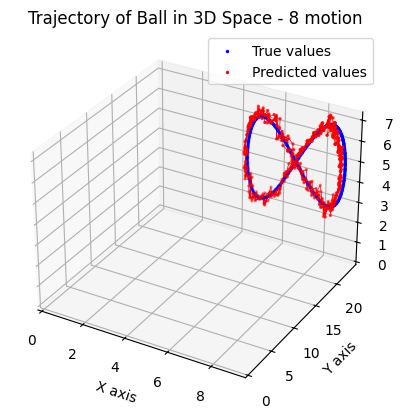

In [43]:
X_test_scaled_8, y_test_8 = prepare_and_scale_test_data(X_test_8, y_test_8, scaler_x)
y_test_pred_8, mse_8, mae_8, r2_8 = predict_evaluate_plot(X_test_scaled_8, y_test_8, model, scaler_y, 'Trajectory of Ball in 3D Space - 8 motion')

Mean Squared Error on Test Data Set: 0.2698910392426343
Mean Absolute Error on Test Data Set: 0.4263249388634159
R2 Score on Test Data set: 0.7914312744847741


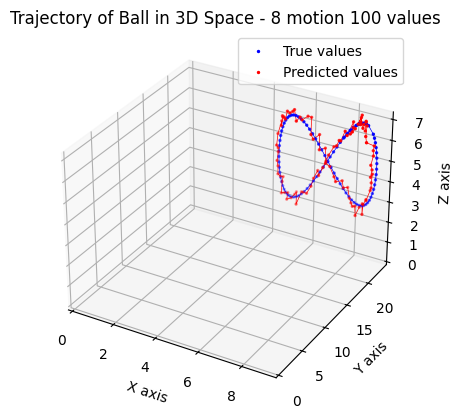

(array([[ 8.1822    , 21.53856417,  6.47697615],
        [ 8.21501268, 22.07195311,  6.68679973],
        [ 8.33135718, 22.5591922 ,  6.79384642],
        [ 8.27417535, 23.75536396,  6.99161361],
        [ 8.38951634, 22.90748929,  6.84430785],
        [ 8.58808038, 22.37456503,  6.70340401],
        [ 8.59093366, 23.07523738,  6.86382531],
        [ 8.65409942, 22.99046886,  6.72243294],
        [ 8.82275574, 21.86879501,  6.46742142],
        [ 8.97823837, 21.2835458 ,  6.32395875],
        [ 9.09771035, 22.55243176,  5.96843449],
        [ 8.98177011, 22.99005889,  5.62684392],
        [ 9.00624472, 22.93139811,  5.39155867],
        [ 9.01008216, 22.37014853,  5.05107262],
        [ 9.0605969 , 22.45305942,  4.82309272],
        [ 9.04728471, 22.21159204,  4.51093756],
        [ 8.98016595, 23.0115376 ,  4.49074472],
        [ 8.99499733, 22.72574151,  4.1276023 ],
        [ 8.99663095, 22.73525273,  3.87306378],
        [ 8.94098528, 22.8327242 ,  3.71257905],
        [ 8.91440152

In [47]:
# make 3d scatter plot of the predicted and actual values
predict_evaluate_plot(X_test_scaled_8[:100], y_test_8[:100], model, scaler_y, 'Trajectory of Ball in 3D Space - 8 motion 100 values')